In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

import requests
import time
import ast
import random

# Spotipy
from dotenv import load_dotenv
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

In [2]:
# import the dataframes
df_uk_masters = pd.read_csv('Datasets/df_uk_masters.csv')                         # all the albums from the UK
df_us_masters = pd.read_csv('Datasets/df_us_masters.csv')                         # albums from the US until 1996, 1998 and 2000
df_us_new_masters = pd.read_csv('Datasets/df_us_new_masters.csv')                         # albums from the US from 1997, 1999 and 2001
df_ratings_20 = pd.read_csv('Datasets/df_ratings_20.csv', keep_default_na=False)  # albums with >= 20 votes, mostly from rock, worldwide
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (until 2000) with >= 20 votes 

# print information
print(f'{df_uk_masters.shape}: df_uk_masters')
print(f'{df_us_masters.shape}: df_us_masters')
print(f'{df_us_new_masters.shape}: df_us_new_masters')
print(f'{df_ratings_20.shape}: df_ratings_20')
print(f'{df_masters_blended.shape}: df_masters_blended')

(56660, 13): df_uk_masters
(48690, 13): df_us_masters
(74652, 13): df_us_new_masters
(51222, 5): df_ratings_20
(9667, 13): df_masters_blended


# **``album_length``**

In [3]:
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (until 2000) with >= 20 votes 
df = df_masters_blended
df.shape

(9667, 13)

In [4]:
percentage_album_length_missing = round((df['album_length']==0).sum() / df.shape[0] * 100, 2)

print(f"albums missing album_length: {(df['album_length']==0).sum()} ")
print(f'% missing album_length: {percentage_album_length_missing}%')

albums missing album_length: 2234 
% missing album_length: 23.11%


In [5]:
df_length_0 = df[df['album_length']==0].sort_values(['artist', 'year', 'title'])
df_length_0.shape

(2234, 13)

## **``Spotipy`` (Spotify API)**

In [6]:
load_dotenv()

True

In [7]:
user = os.getenv('client_id')
password = os.getenv('client_secret')

# Initialize Spotipy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id = user,
                                                           client_secret = password), requests_timeout=10)

### Testing

In [836]:
count = 0
for artist, title in df_length_0[['artist', 'title']][:10].values:
    count+=1

    print(count, artist, title)

1 ...And You Will Know Us by the Trail of Dead Madonna
2 108 Songs of Separation
3 10cc 10cc
4 10cc Sheet Music
5 10cc Deceptive Bends
6 23 Skidoo Seven Songs
7 2:54 2:54
8 7 Seconds The Crew
9 7 Seconds New Wind
10 A Certain Ratio The Graveyard and The Ballroom


In [1025]:
def get_all_albums(artist_id):
    albums = []
    results = sp.artist_albums(artist_id, limit=50)  # First request

    while results:
        albums.extend(results['items'])  # Store the albums
        if results['next']:  # Check if there's another page
            results = sp.next(results)  # Fetch next page
        else:
            break  # Stop when no more pages

    return albums

In [101]:
artist = 'At the Skylines'
title = 'The Secrets To Life'
# other albums by the same artist:
# Kings of the Wild Frontier
# Prince Charming

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

artists = results['artists']['items']
artists_ids = results['artists']['items'] # get the artist_id

for i in range(len(artists)):
    # artist = artists[i]['name']
    try:
        # look for my artist
        if artist.lower().replace('and', '&') == artists[i]['name'].lower():
            # if it finds my artist:
            artist_id = artists_ids[i]['id']
            print('artist found')
            print(artist)

            artist_albums = get_all_albums(artist_id)

            for album in artist_albums:

                print(album['name'])

                # look for my album
                if album['name'].lower().replace('and', '&') == (title.lower().replace('and', '&')):
                    print('album found')
                    album_id = album['id']
                    results = sp.album(album_id)
                    tracks = results['tracks']['items']
                    song_durations = [song['duration_ms']/60000 for song in tracks]
                    
                    album_length = round(sum(song_durations), 2)

                    break   # once it finds the album, stop
    except:
        print('error')            

artist found
At the Skylines
The Secrets To Life (Special Edition)
The Secrets To Life
album found


Autopsy - Severed Survival

In [19]:
artist = 'The Beatles'

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

# theorically the artist should be the first result
artist_name = results['artists']['items'][0]['name']
artist_id = results['artists']['items'][0]['id'] # get the artist_id

if artist_name.lower() == artist.lower():
    print(f"artist found: {artist_name} with id '{artist_id}'")
else:
    print(f"Cannot find '{artist}', try some other one")

artist found: The Beatles with id '3WrFJ7ztbogyGnTHbHJFl2'


In [20]:
albums = get_all_albums('3WrFJ7ztbogyGnTHbHJFl2')

In [21]:
for i in albums:
    print(i['name'])

The Beatles 1967 – 1970 (2023 Edition)
The Beatles 1962 – 1966 (2023 Edition)
Revolver (Super Deluxe)
Get Back (Rooftop Performance)
Let It Be (Super Deluxe)
Abbey Road (Super Deluxe Edition)
The Beatles
Live At The Hollywood Bowl
Yellow Submarine Songtrack
Let It Be... Naked (Remastered)
On Air - Live At The BBC (Vol.2)
Live At The BBC (Remastered)
Let It Be (Remastered)
Abbey Road (Remastered)
Yellow Submarine (Remastered)
The Beatles (Remastered)
Magical Mystery Tour (Remastered)
Sgt. Pepper's Lonely Hearts Club Band (Remastered)
Sgt. Pepper's Lonely Hearts Club Band (Deluxe Edition)
Sgt. Pepper's Lonely Hearts Club Band (Super Deluxe Edition)
Revolver (Remastered)
Rubber Soul (Remastered 2009)
Help! (Remastered)
Beatles For Sale (Remastered)
A Hard Day's Night (Remastered)
With The Beatles (Remastered)
Please Please Me (Remastered)
Now And Then
Beatles '64 (Music from the Disney+ Documentary)
Love
1 (Remastered)
Anthology 3
Anthology 2
Anthology 1
Past Masters (Vols. 1 & 2 / Remast

In [251]:
albums[0]

{'album_type': 'album',
 'total_tracks': 16,
 'available_markets': ['AR',
  'AU',
  'AT',
  'BE',
  'BO',
  'BR',
  'BG',
  'CL',
  'CO',
  'CR',
  'CY',
  'CZ',
  'DK',
  'DO',
  'DE',
  'EC',
  'EE',
  'SV',
  'FI',
  'FR',
  'GR',
  'GT',
  'HN',
  'HK',
  'HU',
  'IS',
  'IE',
  'IT',
  'LV',
  'LT',
  'LU',
  'MY',
  'MT',
  'MX',
  'NL',
  'NZ',
  'NI',
  'NO',
  'PA',
  'PY',
  'PE',
  'PH',
  'PL',
  'PT',
  'SG',
  'SK',
  'ES',
  'SE',
  'CH',
  'TW',
  'TR',
  'UY',
  'GB',
  'AD',
  'LI',
  'MC',
  'ID',
  'JP',
  'TH',
  'VN',
  'RO',
  'IL',
  'ZA',
  'SA',
  'AE',
  'BH',
  'QA',
  'OM',
  'KW',
  'EG',
  'MA',
  'DZ',
  'TN',
  'LB',
  'JO',
  'PS',
  'IN',
  'BY',
  'KZ',
  'MD',
  'UA',
  'AL',
  'BA',
  'HR',
  'ME',
  'MK',
  'RS',
  'SI',
  'KR',
  'BD',
  'PK',
  'LK',
  'GH',
  'KE',
  'NG',
  'TZ',
  'UG',
  'AG',
  'AM',
  'BS',
  'BB',
  'BZ',
  'BT',
  'BW',
  'BF',
  'CV',
  'CW',
  'DM',
  'FJ',
  'GM',
  'GE',
  'GD',
  'GW',
  'GY',
  'HT',
  'JM',
  'KI'

In [218]:
sp.album('4YusrgALyy8DNAH1912lho')

{'album_type': 'album',
 'total_tracks': 12,
 'available_markets': ['AR',
  'BE',
  'BO',
  'BR',
  'CA',
  'CL',
  'CO',
  'CR',
  'CY',
  'DK',
  'DO',
  'EC',
  'SV',
  'FI',
  'FR',
  'GR',
  'GT',
  'HN',
  'IS',
  'IE',
  'IT',
  'LU',
  'MT',
  'MX',
  'NL',
  'NI',
  'NO',
  'PA',
  'PY',
  'PE',
  'PT',
  'ES',
  'SE',
  'TR',
  'UY',
  'US',
  'GB',
  'AD',
  'MC',
  'JP',
  'IL',
  'ZA',
  'SA',
  'AE',
  'BH',
  'QA',
  'OM',
  'KW',
  'EG',
  'MA',
  'DZ',
  'TN',
  'LB',
  'JO',
  'PS',
  'IN',
  'BY',
  'KZ',
  'MD',
  'UA',
  'KR',
  'BD',
  'PK',
  'LK',
  'GH',
  'KE',
  'NG',
  'TZ',
  'UG',
  'AG',
  'AM',
  'BS',
  'BB',
  'BZ',
  'BW',
  'BF',
  'CV',
  'CW',
  'DM',
  'FJ',
  'GM',
  'GE',
  'GD',
  'GW',
  'HT',
  'JM',
  'LS',
  'LR',
  'MW',
  'ML',
  'FM',
  'NA',
  'NE',
  'PG',
  'PR',
  'SM',
  'ST',
  'SN',
  'SC',
  'SL',
  'KN',
  'LC',
  'VC',
  'TT',
  'AZ',
  'BI',
  'CM',
  'TD',
  'KM',
  'GQ',
  'SZ',
  'GA',
  'GN',
  'KG',
  'MR',
  'MN',
  'NP'

In [81]:
album_id

'0c3seOACinoYTZ0GxtjxCv'

In [146]:
results = sp.album(album_id)

In [147]:
results['tracks']['items'][0]['duration_ms']

217373

Here we can see that the album is found, though not on the exact same name, it doesn't do an exact match because there are other parts in the title, such as **'Deluxe Edition'** or **'Remastered'**

In [1078]:
len(artist_albums)

31

In [1082]:
artist_albums[0]['name']

'Kings of the Wild Frontier (Deluxe Edition)'

In [952]:
artist_id

'2jK54ZlZhTF1TxygsVeR05'

### **define the function**

In [8]:
def get_album_length(df):
    count = 0
    scraped = 0

    # create empty lists
    artists_list = []
    albums_list = []
    albums_lengths = []
    tracks_list = []
    album_name_list = []

    for artist in df['artist'].unique():
        time.sleep(1)

        results = sp.search(q = artist
                            , type = 'artist'
                            , limit = 5)

        artists = results['artists']['items']
        artists_ids = results['artists']['items'] # get the artist_id

        for i in range(len(artists)):
            artist_name = artists[i]['name'].lower()
            artist_name_and = artist.replace('and', '&').lower()
            try:
                # look for my artist
                if artist_name == artist.lower() or artist_name == artist_name_and:
                    
                    # if it finds my artist:
                    artist_id = artists_ids[i]['id']
                    artist_albums = get_all_albums(artist_id)
                    
                    for title in df[df['artist']==artist]['title'].values:
                        time.sleep(1)
                        count+=1
                        title_clean = title.replace('and', '&').lower()

                        for album in artist_albums:
                            album_name = album['name'].lower()
                               
                            if title_clean == album_name:
                                artists_list.append(artist)
                                albums_list.append(title)
                                album_name_list.append(album_name)

                                album_id = album['id']
                                results = sp.album(album_id)
                                tracks = results['tracks']['items']
                                tracks_list.append(len(tracks))
                                
                                song_durations = [song['duration_ms']/60000 for song in tracks]
                                
                                album_length = round(sum(song_durations), 2)
                                albums_lengths.append(album_length)
                                scraped+=1

                            # once it finds the album, stop
                                print(f"{scraped}/{count}: {artist} - {title}, exact match")
                                break
                        else:
                            for album in artist_albums:
                                album_name = album['name'].lower()

                                if title_clean in album_name:
                                    artists_list.append(artist)
                                    albums_list.append(title)
                                    album_name_list.append(album_name)

                                    album_id = album['id']
                                    results = sp.album(album_id)
                                    tracks = results['tracks']['items']
                                    tracks_list.append(len(tracks))

                                    song_durations = [song['duration_ms']/60000 for song in tracks]
                                    
                                    album_length = round(sum(song_durations), 2)
                                    albums_lengths.append(album_length)
                                    scraped+=1

                                # once it finds the album, stop
                                    print(f"{scraped}/{count}: {artist} - {title}, similar match")
                                    break

                # when it checks all the albums of that artist, stop    
                    break

            except:
                print('error')
                albums_lengths.append(np.nan)
                tracks_list.append(np.nan)
                break

        lists = [artists_list, albums_list, album_name_list, albums_lengths, tracks_list]

    # Check if all lists have the same length
        lengths = [len(lst) for lst in lists]

        if len(set(lengths)) != 1:
            print("Lengths are not the same.")
            break # stop the loop, I won't be able to store the data if I have one value missing

    df_lengths_missing = pd.DataFrame({'artist': artists_list,
                                    'title': albums_list,
                                    'name': album_name_list,
                                    'album_length': albums_lengths,
                                    'tracks': tracks_list})
    return df_lengths_missing

In [9]:
def get_all_albums(artist_id):
    albums = []
    results = sp.artist_albums(artist_id, limit=50)  # First request

    while results:
        albums.extend(results['items'])  # Store the albums
        if results['next']:  # Check if there's another page
            results = sp.next(results)  # Fetch next page
        else:
            break  # Stop when no more pages

    return albums

**La següent funciona però no és la millor**

In [160]:
def get_album_length(df):
    count = 0
    scraped = 0

    # create empty lists
    artists_list = []
    albums_list = []
    albums_lengths = []
    tracks_list = []

    for artist, title in df[['artist', 'title']].values:
        time.sleep(1)
        count+=1

        artists_list.append(artist)
        albums_list.append(title)

        results = sp.search(q = artist
                            , type = 'artist'
                            , limit = 5)

        artists = results['artists']['items']
        artists_ids = results['artists']['items'] # get the artist_id

        for i in range(len(artists)):
            artist_name = artists[i]['name'].lower()
            artist_name_and = artist.replace('and', '&').lower()
            try:
                # look for my artist
                if artist_name == artist.lower() or artist_name == artist_name_and:
                    # if it finds my artist:
                    artist_id = artists_ids[i]['id']

                    artist_albums = get_all_albums(artist_id)

                    for album in artist_albums:
                        album_name = album['name'].lower()        
                        title_name_and = title.replace('and', '&').lower()
                        if title.lower() in album_name or title_name_and in album_name:
                            album_id = album['id']
                            results = sp.album(album_id)
                            tracks = results['tracks']['items']
                            tracks_list.append(len(tracks))
                            song_durations = [song['duration_ms']/60000 for song in tracks]
                            
                            album_length = round(sum(song_durations), 2)
                            albums_lengths.append(album_length)
                            scraped+=1
                            break   # once it finds the album, stop
                    else:
                        continue
                    break 
            except:
                print('error')
                albums_lengths.append(np.nan)
                tracks_list.append(np.nan)
                break
        
        else:
            albums_lengths.append(np.nan)
            tracks_list.append(np.nan)

        print(f"{scraped}/{count}: {artist} - {title}")

        lists = [artists_list, albums_list, albums_lengths, tracks_list]

    # Check if all lists have the same length
        lengths = [len(lst) for lst in lists]
        if len(set(lengths)) != 1:
            print("Lengths are not the same.")
            break # stop the loop, I won't be able to store the data if I have one value missing

    df_lengths_missing = pd.DataFrame({'artist': artists_list,
                                    'title': albums_list,
                                    'album_length': albums_lengths,
                                    'tracks': tracks_list})
    return df_lengths_missing

### **Get the ``album_length`` from Spotipy**

In [16]:
start_index = 2000
end_index = start_index + 300

df_lengths_missing = get_album_length(df_length_0.iloc[start_index:end_index])
df_lengths_missing.shape

1/1: The White Stripes - De Stijl, exact match
2/2: The Who - My Generation, similar match
3/3: The Who - A Quick One, exact match
4/4: The Who - The Who Sell Out, exact match
5/5: The Who - Quadrophenia, exact match
6/6: The Who - Odds and Sods, exact match
7/7: The Who - The Who by Numbers, exact match
8/8: The Who - Who Are You, exact match
9/9: The Who - It's Hard, exact match
10/10: The Wildhearts - Fishing For Luckies, similar match
11/11: The Wildhearts - Renaissance Men, exact match
12/12: The Wildhearts - 21st Century Love Songs, exact match
13/13: The Wonder Years - Sister Cities, exact match
14/14: The Xcerts - In The Cold Wind We Smile, similar match
15/15: The Xcerts - Scatterbrain, exact match
16/16: The Xcerts - Hold On To Your Heart, exact match
17/17: The Yardbirds - Five Live Yardbirds, exact match
18/18: The Yardbirds - For Your Love, exact match
19/19: The Yardbirds - Little Games, exact match
20/20: The Young Veins - Take a Vacation!, similar match
21/21: The Zombi

(198, 5)

In [12]:
minutes = 17
attempts = 434

seconds_per_attempt = minutes*60/attempts
seconds_per_attempt 

2.3502304147465436

In [17]:
df_lengths_missing.sort_values('tracks', ascending=False).head()

,artist,title,name,album_length,tracks
112,Virgin Steele,Life Among The Ruins,life among the ruins,152.21,39
173,Yes,The Yes Album,the yes album (super deluxe edition),259.04,36
77,UFO,Phenomenon,phenomenon [deluxe edition],148.02,34
180,Young Marble Giants,Colossal Youth,colossal youth (40th anniversary edition),67.93,29
42,Titus Andronicus,The Most Lamentable Tragedy,the most lamentable tragedy,92.82,29


<Axes: xlabel='tracks'>

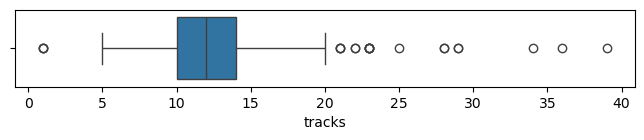

In [18]:
plt.figure(figsize=(8,1))
sns.boxplot(x=df_lengths_missing['tracks'])

In [19]:
df_lengths_missing.sort_values('album_length', ascending=False).head()

,artist,title,name,album_length,tracks
173,Yes,The Yes Album,the yes album (super deluxe edition),259.04,36
112,Virgin Steele,Life Among The Ruins,life among the ruins,152.21,39
77,UFO,Phenomenon,phenomenon [deluxe edition],148.02,34
157,Wishbone Ash,Argus,argus (deluxe edition),141.97,18
175,Yes,Drama,topographic drama: live across america,136.82,13


<Axes: xlabel='album_length'>

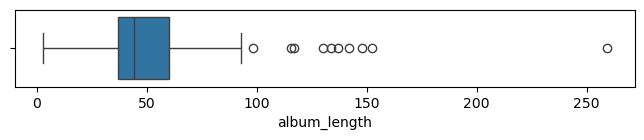

In [20]:
plt.figure(figsize=(8,1))
sns.boxplot(x=df_lengths_missing['album_length'])

In [21]:
df_lengths_missing.to_csv('Datasets/df_lengths_missing_4.csv', index=False)

In [22]:
df_lengths_missing_1 = pd.read_csv('Datasets/df_lengths_missing_1.csv')
df_lengths_missing_1.shape

(1116, 5)

In [23]:
df_lengths_missing_2 = pd.read_csv('Datasets/df_lengths_missing_2.csv')
df_lengths_missing_2.shape

(434, 5)

In [24]:
df_lengths_missing_3 = pd.read_csv('Datasets/df_lengths_missing_3.csv')
df_lengths_missing_3.shape

(174, 5)

In [25]:
df_lengths_missing_4 = pd.read_csv('Datasets/df_lengths_missing_4.csv')
df_lengths_missing_4.shape

(198, 5)

In [26]:
df_lengths_missing_concat = pd.concat([df_lengths_missing_1, df_lengths_missing_2, df_lengths_missing_3, df_lengths_missing_4])
df_lengths_missing_concat.shape

(1922, 5)

In [27]:
df_lengths_missing_concat.to_csv('Datasets/df_lengths_missing_concat.csv', index=False)

<Axes: xlabel='tracks'>

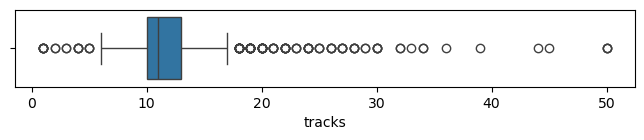

In [318]:
plt.figure(figsize=(8,1))
sns.boxplot(x=df_lengths_missing_concat['tracks'])

<Axes: xlabel='album_length'>

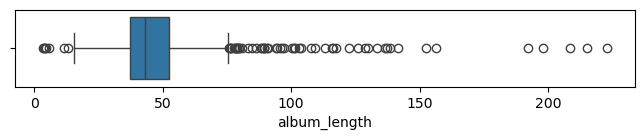

In [319]:
plt.figure(figsize=(8,1))
sns.boxplot(x=df_lengths_missing_concat['album_length'])

In [11]:
df_length_0['artist'].value_counts().head(10)

artist
The Fall              10
The Kinks             10
Hawkwind              10
Pink Floyd             9
The Mountain Goats     9
Genesis                9
Elton John             9
The Who                8
The Beatles            8
Black Sabbath          8
Name: count, dtype: int64

In [12]:
df_length_0.shape

(2234, 13)

In [13]:
df_length_0['artist'].nunique()

1442